In [90]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,\
      mean_squared_log_error, mean_absolute_error, make_scorer, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import shap
from xgboost import XGBRegressor

In [91]:
data = pd.read_csv('data.csv')

In [92]:
data.set_index('OSEBuildingID', inplace = True)

In [93]:
cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUseWN(kBtu)', 'Age',]

NumberofBuildings
32.32724400559336


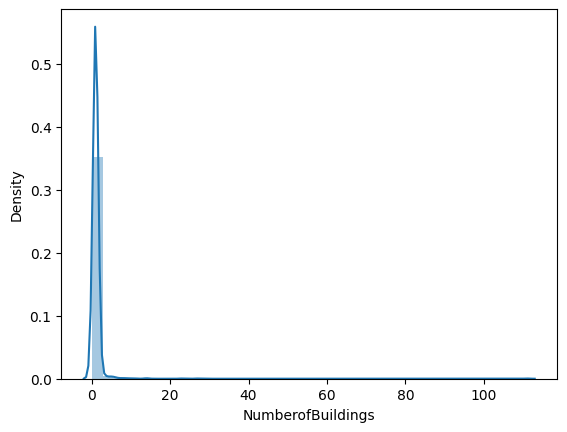

NumberofFloors
6.006854939731992


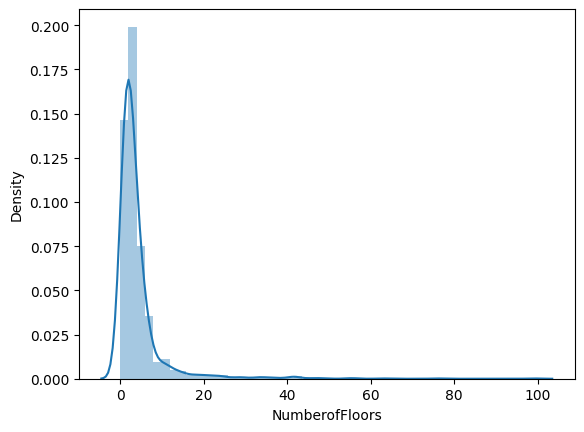

PropertyGFATotal
19.037917545145827


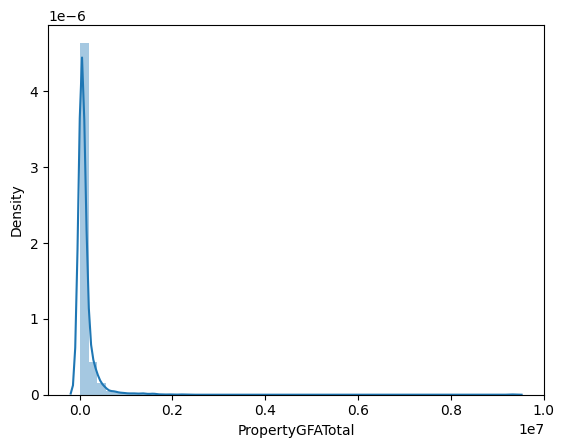

LargestPropertyUseTypeGFA
23.175161728669494


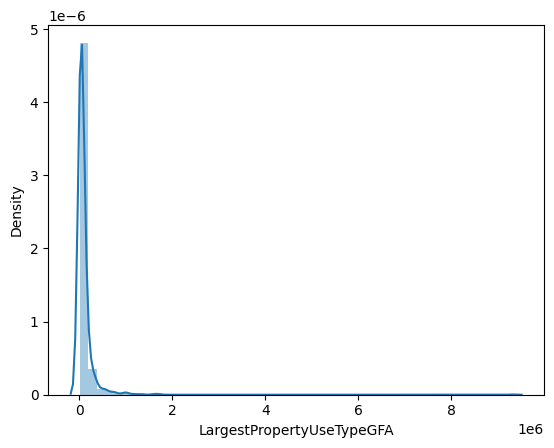

ENERGYSTARScore
-0.7540916788099522


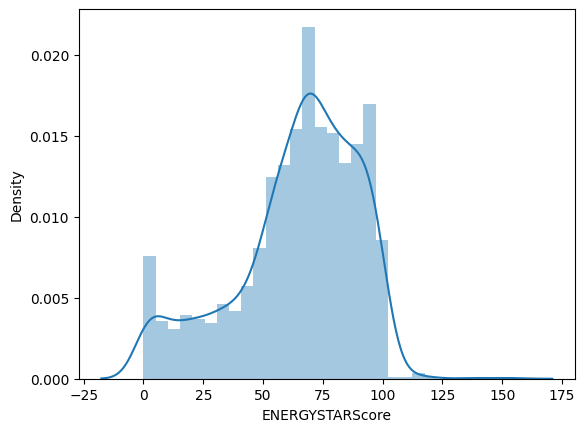

SiteEnergyUseWN(kBtu)
11.278401485274577


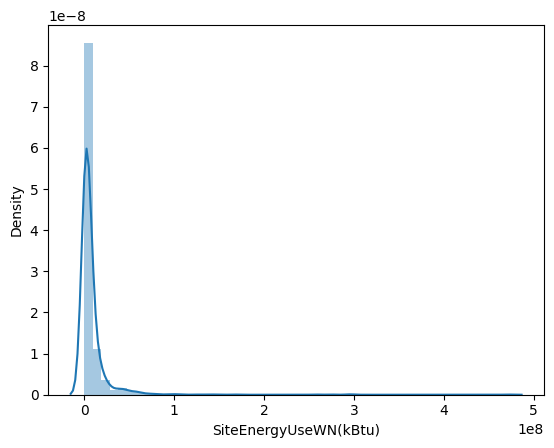

Age
0.29753360879193896


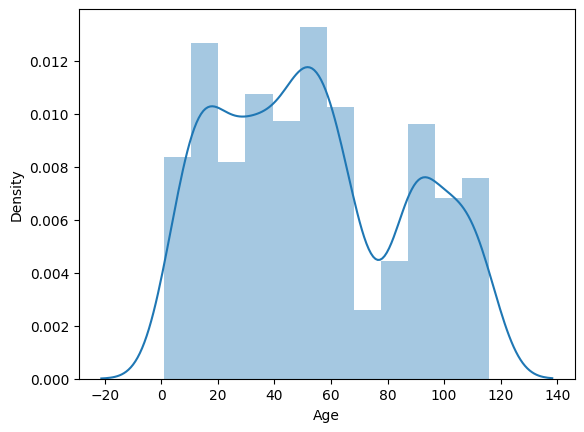

In [94]:
for col in cols:
      print(col)
      print(skew(data[col]))

      plt.figure()
      sns.distplot(data[col])
      plt.show()

<AxesSubplot: >

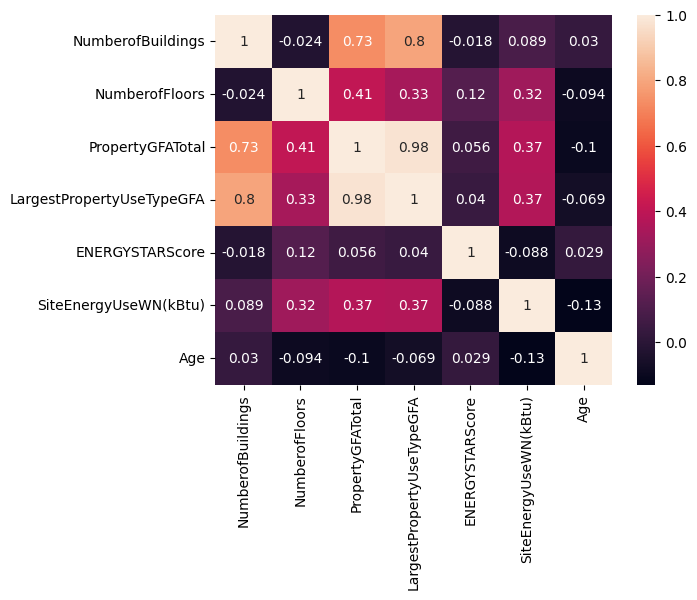

In [95]:
sns.heatmap(data[cols].corr(), annot = True)

In [96]:
data =data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [97]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal',
        'PropertyGFAParking(%)','PropertyGFABuilding(s)(%)',
        'LargestPropertyUseTypeGFA','ENERGYSTARScore',
        'PrimaryPropertyType_Distribution Center',
        'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]

y = data['SiteEnergyUseWN(kBtu)']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
colsk = ['NumberofFloors','PropertyGFATotal',
'LargestPropertyUseTypeGFA']
X_train_tt = X_train.copy()
X_test_tt = X_test.copy()
X_train_tt[colsk] = np.log1p(X_train_tt[colsk])
X_test_tt[colsk] = np.log1p(X_test_tt[colsk])

In [100]:
std_scale = StandardScaler()
std_scale.fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
std_scale_tt = StandardScaler()
std_scale_tt.fit(X_train_tt)
X_train_tt = std_scale_tt.transform(X_train_tt)
X_test_tt = std_scale_tt.transform(X_test_tt)

In [101]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
X_train_tt = pd.DataFrame(X_train_tt, columns = X.columns)
X_test_tt = pd.DataFrame(X_test_tt, columns = X.columns)

In [102]:
dr = DummyRegressor(strategy='mean')
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)
baseline_error = mean_squared_error(y_test, y_pred, squared=False)
baseline_error

23631173.53272141

In [103]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_error = mean_squared_error(y_test, y_pred, squared=False)
lr_error

20497430.21033486

In [104]:
def resultize(grid):

    res = pd.DataFrame(grid.cv_results_)
    res = res[['params', 'mean_test_RMSE', 'rank_test_RMSE', 'mean_test_MSE', 'rank_test_MSE', 'mean_test_MAE', 'rank_test_MAE', 'mean_test_R2', 'rank_test_R2']]
    res['mean_test_MSE'] = (-res[f'mean_test_MSE'])
    res['mean_test_RMSE'] = (-res[f'mean_test_RMSE'])
    res['mean_test_MAE'] = (-res[f'mean_test_MAE'])
    res.sort_values(by='rank_test_RMSE', inplace=True)
    return res

In [105]:
s = {'MSE': 'neg_mean_squared_error', 
      'RMSE': 'neg_root_mean_squared_error',
      'MAE': 'neg_mean_absolute_error',
      'R2': 'r2'}
score = 'RMSE'

In [106]:
params = {'alpha': np.logspace(0, 7, 20)}
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, params, cv=10, scoring = s , refit = score, n_jobs=-1)
grid_ridge.fit(X_train, y_train)
grid_ridge_best_params = grid_ridge.best_params_
resultize(grid_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
9,{'alpha': 2069.138081114788},1.778064e+07,1,4.189634e+14,1,6.460011e+06,4,0.105744,3
10,{'alpha': 4832.930238571752},1.793505e+07,2,4.235095e+14,2,7.137980e+06,9,0.160784,1
8,{'alpha': 885.8667904100823},1.838290e+07,3,4.578626e+14,5,6.012922e+06,1,-0.254810,12
11,{'alpha': 11288.378916846883},1.844058e+07,4,4.410908e+14,3,7.764738e+06,12,0.108768,2
12,{'alpha': 26366.508987303554},1.888540e+07,5,4.560541e+14,4,8.183743e+06,13,0.050493,4


In [107]:
grid_ridge_best_params = {'alpha': 2069.138081114788}

In [108]:
ridge = Ridge(**grid_ridge_best_params)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_error = mean_squared_error(y_test, y_pred, squared=False)
ridge_error

21623645.617888987

In [109]:
'''params = {'alpha': np.logspace(-3, 10, 200)}
grid_lasso = GridSearchCV(Lasso(), params, cv=10, scoring = s , refit = score, n_jobs=-1)
grid_lasso.fit(X_train, y_train)
grid_lasso_best_params = grid_lasso.best_params_
resultize(grid_lasso).head()'''

"params = {'alpha': np.logspace(-3, 10, 200)}\ngrid_lasso = GridSearchCV(Lasso(), params, cv=10, scoring = s , refit = score, n_jobs=-1)\ngrid_lasso.fit(X_train, y_train)\ngrid_lasso_best_params = grid_lasso.best_params_\nresultize(grid_lasso).head()"

In [110]:
grid_lasso_best_params = {'alpha': 6294988.990221888}

In [111]:
lasso = Lasso(**grid_lasso_best_params)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_error = mean_squared_error(y_test, y_pred, squared=False)
lasso_error

23144705.019516427

In [112]:
tt_ridge = TransformedTargetRegressor(regressor=Ridge(), 
                                    func=np.log1p, 
                                    inverse_func=np.expm1)
params = {'regressor__alpha': np.logspace(0, 7, 100)}
grid_tt_ridge = GridSearchCV(tt_ridge, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_ridge.fit(X_train_tt, y_train)
grid_tt_ridge_best_params = grid_tt_ridge.best_params_
resultize(grid_tt_ridge).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
45,{'regressor__alpha': 1519.9110829529332},1.825604e+07,1,4.353517e+14,1,5.349381e+06,5,0.124640,2
46,{'regressor__alpha': 1788.649529057435},1.832929e+07,2,4.391795e+14,3,5.444314e+06,6,0.127783,1
44,{'regressor__alpha': 1291.549665014884},1.834352e+07,3,4.372002e+14,2,5.266067e+06,3,0.077403,5
47,{'regressor__alpha': 2104.9041445120197},1.847259e+07,4,4.448547e+14,4,5.542313e+06,7,0.114412,3
48,{'regressor__alpha': 2477.076355991709},1.863905e+07,5,4.509340e+14,5,5.640860e+06,9,0.095105,4


In [113]:
grid_tt_ridge_best_params = {'alpha': 1519.9110829529332}

In [114]:
tt_ridge = TransformedTargetRegressor(
      regressor=Ridge(**grid_tt_ridge_best_params),
      func=np.log1p,
        inverse_func=np.expm1)
tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
tt_ridge_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ridge_error

23649571.600726414

In [115]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__alpha': np.logspace(-1, 3, 30)}
grid_tt_lasso = GridSearchCV(tt_lasso, scoring=s, refit = score, param_grid=params, cv = 10)
grid_tt_lasso.fit(X_train, y_train)
grid_tt_lasso_best_params = grid_tt_lasso.best_params_
resultize(grid_tt_lasso).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
4,{'regressor__alpha': 0.3562247890262442},1.952933e+07,1,4.824110e+14,1,6.404013e+06,1,-0.025080,1
5,{'regressor__alpha': 0.4893900918477494},1.996968e+07,2,4.975277e+14,2,6.626819e+06,2,-0.088391,2
14,{'regressor__alpha': 8.531678524172806},2.013949e+07,3,5.032811e+14,3,6.723646e+06,3,-0.114462,3
27,{'regressor__alpha': 529.8316906283708},2.013949e+07,3,5.032811e+14,3,6.723646e+06,3,-0.114462,3
26,{'regressor__alpha': 385.6620421163472},2.013949e+07,3,5.032811e+14,3,6.723646e+06,3,-0.114462,3


In [116]:
grid_tt_lasso_best_params = {'alpha': 0.3562247890262442}

In [117]:
tt_lasso = TransformedTargetRegressor(regressor = Lasso(**grid_tt_lasso_best_params),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_lasso.fit(X_train, y_train)
y_pred = tt_lasso.predict(X_test)
tt_lasso_error = mean_squared_error(y_test, y_pred, squared=False)
tt_lasso_error

24769617.95754796

In [118]:
params = {'kernel': ['sigmoid','rbf','poly'],
         'C': [0.1,1,100,1000],
         'degree': [1,2,3,4,5,6]}
grid_svr = GridSearchCV(SVR(), params, cv=10, scoring = s,
                        refit = score,  n_jobs=-1)
grid_svr.fit(X_train, y_train)
best_params_svr = grid_svr.best_params_
resultize(grid_svr).head()

,params,mean_test_RMSE,rank_test_RMSE,mean_test_MSE,rank_test_MSE,mean_test_MAE,rank_test_MAE,mean_test_R2,rank_test_R2
56,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",2.006030e+07,1,5.004959e+14,1,6.694916e+06,1,-0.102229,1
66,"{'C': 1000, 'degree': 5, 'kernel': 'sigmoid'}",2.006341e+07,2,5.005969e+14,2,6.697627e+06,2,-0.102724,2
54,"{'C': 1000, 'degree': 1, 'kernel': 'sigmoid'}",2.006341e+07,2,5.005969e+14,2,6.697627e+06,2,-0.102724,2
57,"{'C': 1000, 'degree': 2, 'kernel': 'sigmoid'}",2.006341e+07,2,5.005969e+14,2,6.697627e+06,2,-0.102724,2
69,"{'C': 1000, 'degree': 6, 'kernel': 'sigmoid'}",2.006341e+07,2,5.005969e+14,2,6.697627e+06,2,-0.102724,2


In [119]:
grid_svr_best_params = {'C': 1000, 'degree': 1, 'kernel': 'poly'}

In [120]:
svr = SVR(**grid_svr_best_params)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_error = mean_squared_error(y_test, y_pred, squared=False)
svr_error

24289048.33607608

In [121]:
"""tt_svr = TransformedTargetRegressor(regressor = SVR(),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
params = {'regressor__C': [0.1,1,100,1000],
            'regressor__degree': [1,2,3,4,5,6],
            'regressor__kernel': ['sigmoid','rbf','poly']}
grid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_svr.fit(X_train_tt, y_train)
best_params_svr_tt = grid_tt_svr.best_params_
resultize(grid_tt_svr).head()"""


"tt_svr = TransformedTargetRegressor(regressor = SVR(),\n                                    func = np.log1p,\n                                    inverse_func = np.expm1)\nparams = {'regressor__C': [0.1,1,100,1000],\n            'regressor__degree': [1,2,3,4,5,6],\n            'regressor__kernel': ['sigmoid','rbf','poly']}\ngrid_tt_svr = GridSearchCV(tt_svr, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_svr.fit(X_train_tt, y_train)\nbest_params_svr_tt = grid_tt_svr.best_params_\nresultize(grid_tt_svr).head()"

In [122]:
best_params_svr_tt = {'C': 1, 'degree': 1, 'kernel': 'rbf'}

In [123]:
tt_svr = TransformedTargetRegressor(regressor = SVR(**best_params_svr_tt),
                                    func = np.log1p,
                                    inverse_func = np.expm1)
tt_svr.fit(X_train_tt, y_train)
y_pred = tt_svr.predict(X_test_tt)
tt_svr_error = mean_squared_error(y_test, y_pred, squared=False)
tt_svr_error

15286624.857983483

In [124]:
'''params = {'n_estimators': [10, 100, 1000],
            'max_depth': [1, 10, 100, 1000],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()'''
#1mn

"params = {'n_estimators': [10, 100, 1000],\n            'max_depth': [1, 10, 100, 1000],\n            'min_samples_split': [2, 5, 10],\n            'min_samples_leaf': [1, 2, 4]}\ngrid_rf = GridSearchCV(RandomForestRegressor(), params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_rf.fit(X_train, y_train)\nbest_params_rf = grid_rf.best_params_\nresultize(grid_rf).head()"

In [125]:
best_params_rf = {'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [126]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_error = mean_squared_error(y_test, y_pred, squared=False)
rf_error

18174843.2522029

In [127]:
'''tt_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [10, 100, 1000],
            'regressor__max_depth': [1, 10, 100, 1000],
            'regressor__min_samples_split': [2, 5, 10],    
            'regressor__min_samples_leaf': [1, 2, 4]}
grid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_rf.fit(X_train_tt, y_train)
best_params_rf_tt = grid_tt_rf.best_params_
resultize(grid_tt_rf).head()'''
#1m17s

"tt_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__n_estimators': [10, 100, 1000],\n            'regressor__max_depth': [1, 10, 100, 1000],\n            'regressor__min_samples_split': [2, 5, 10],    \n            'regressor__min_samples_leaf': [1, 2, 4]}\ngrid_tt_rf = GridSearchCV(tt_rf, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_rf.fit(X_train_tt, y_train)\nbest_params_rf_tt = grid_tt_rf.best_params_\nresultize(grid_tt_rf).head()"

In [128]:
best_params_rf_tt = {'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [129]:
tt_rf = TransformedTargetRegressor(regressor=RandomForestRegressor(**best_params_rf_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_rf.fit(X_train_tt, y_train)
y_pred = tt_rf.predict(X_test_tt)
tt_rf_error = mean_squared_error(y_test, y_pred, squared=False)
tt_rf_error

13801723.436636057

In [130]:
'''params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [4, 6],
            'min_samples_leaf': [3, 5, 9, 17],
}
grid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_gb.fit(X_train, y_train)
best_params_gb = grid_gb.best_params_
resultize(grid_gb).head()'''

"params = {'loss': ['ls', 'lad', 'huber', 'quantile'],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [4, 6],\n            'min_samples_leaf': [3, 5, 9, 17],\n}\ngrid_gb = GridSearchCV(GradientBoostingRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_gb.fit(X_train, y_train)\nbest_params_gb = grid_gb.best_params_\nresultize(grid_gb).head()"

In [131]:
best_params_gb = {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 6, 'min_samples_leaf': 17}

In [132]:
gb = GradientBoostingRegressor(**best_params_gb)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb_error = mean_squared_error(y_test, y_pred, squared=False)
gb_error

16916414.10604027

In [133]:
'''tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()'''
#30s

"tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [4, 6],\n            'regressor__min_samples_leaf': [3, 5, 9, 17]}\ngrid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_gb.fit(X_train_tt, y_train)\nbest_params_gb_tt = grid_tt_gb.best_params_\nresultize(grid_tt_gb).head()"

In [134]:
best_params_gb_tt = {'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 4,
 'min_samples_leaf': 9}

In [135]:
tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(**best_params_gb_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_gb.fit(X_train_tt, y_train)
y_pred = tt_gb.predict(X_test_tt)
tt_gb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error

12661584.84784855

In [136]:
'''ad = AdaBoostRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'loss': ['linear', 'square', 'exponential'],
}
grid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_ad.fit(X_train, y_train)
best_params_ad = grid_ad.best_params_
resultize(grid_ad).head()'''
#30s

"ad = AdaBoostRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'loss': ['linear', 'square', 'exponential'],\n}\ngrid_ad = GridSearchCV(AdaBoostRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_ad.fit(X_train, y_train)\nbest_params_ad = grid_ad.best_params_\nresultize(grid_ad).head()"

In [137]:
best_params_ad = {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 200}

In [138]:
ad = AdaBoostRegressor(**best_params_ad)
ad.fit(X_train, y_train)
y_pred = ad.predict(X_test)
ad_error = mean_squared_error(y_test, y_pred, squared=False)
ad_error

14529152.40184723

In [139]:
'''tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__loss': ['linear', 'square', 'exponential'],
}
grid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_ad.fit(X_train_tt, y_train)
best_params_ad_tt = grid_tt_ad.best_params_
resultize(grid_tt_ad).head()'''
#30s

"tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__loss': ['linear', 'square', 'exponential'],\n}\ngrid_tt_ad = GridSearchCV(tt_ad, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_ad.fit(X_train_tt, y_train)\nbest_params_ad_tt = grid_tt_ad.best_params_\nresultize(grid_tt_ad).head()"

In [140]:
best_params_ad_tt = {'learning_rate': 0.01,
      'loss': 'exponential',
      'n_estimators': 100}

In [141]:
tt_ad = TransformedTargetRegressor(regressor=AdaBoostRegressor(**best_params_ad_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_ad.fit(X_train_tt, y_train)
y_pred = tt_ad.predict(X_test_tt)
tt_ad_error = mean_squared_error(y_test, y_pred, squared=False)
tt_ad_error

21297519.53622366

In [142]:
"""mlp = MLPRegressor()
params = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'adam'],
}
grid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_params_mlp = grid_mlp.best_params_
resultize(grid_mlp).head()"""
#1m30s

"mlp = MLPRegressor()\nparams = {'hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'solver': ['lbfgs', 'adam'],\n}\ngrid_mlp = GridSearchCV(MLPRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_mlp.fit(X_train, y_train)\nbest_params_mlp = grid_mlp.best_params_\nresultize(grid_mlp).head()"

In [143]:
best_params_mlp = {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'solver': 'lbfgs'}

In [144]:
mlp = MLPRegressor(**best_params_mlp)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
mlp_error = mean_squared_error(y_test, y_pred, squared=False)
mlp_error

21906330.429467995

In [145]:
"""tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],
            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'regressor__solver': ['lbfgs', 'adam'],
}
grid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_mlp.fit(X_train_tt, y_train)
best_params_mlp_tt = grid_tt_mlp.best_params_
resultize(grid_tt_mlp).head()"""
#1m30s

"tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__hidden_layer_sizes': [(100,),(200,),(300,),(400,),(500,)],\n            'regressor__activation': ['identity', 'logistic', 'tanh', 'relu'],\n            'regressor__solver': ['lbfgs', 'adam'],\n}\ngrid_tt_mlp = GridSearchCV(tt_mlp, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_mlp.fit(X_train_tt, y_train)\nbest_params_mlp_tt = grid_tt_mlp.best_params_\nresultize(grid_tt_mlp).head()"

In [146]:
best_params_mlp_tt = {'activation': 'logistic',
 'hidden_layer_sizes': (500,),
 'solver': 'lbfgs'}

In [147]:
tt_mlp = TransformedTargetRegressor(regressor=MLPRegressor(**best_params_mlp_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_mlp.fit(X_train_tt, y_train)
y_pred = tt_mlp.predict(X_test_tt)
tt_mlp_error = mean_squared_error(y_test, y_pred, squared=False)
tt_mlp_error

21211649.908665594

In [148]:
'''xgb = XGBRegressor()
params = {'n_estimators': [100, 200, 300, 400, 500],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth': [2, 3, 4, 5, 6]}
grid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_params_xgb = grid_xgb.best_params_
resultize(grid_xgb).head()'''

"xgb = XGBRegressor()\nparams = {'n_estimators': [100, 200, 300, 400, 500],\n            'learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'max_depth': [2, 3, 4, 5, 6]}\ngrid_xgb = GridSearchCV(XGBRegressor(), params, cv=10, scoring = s, refit = score, n_jobs=-1)\ngrid_xgb.fit(X_train, y_train)\nbest_params_xgb = grid_xgb.best_params_\nresultize(grid_xgb).head()"

In [149]:
best_params_xgb = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}

In [150]:
xgb = XGBRegressor(**best_params_xgb)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_error = mean_squared_error(y_test, y_pred, squared=False)
xgb_error

17715215.018670805

In [151]:
'''tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__n_estimators': [100, 200, 300, 400, 500],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [2, 3, 4, 5, 6]}
grid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_xgb.fit(X_train_tt, y_train)
best_params_xgb_tt = grid_tt_xgb.best_params_
resultize(grid_tt_xgb).head()'''
#30s

"tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__n_estimators': [100, 200, 300, 400, 500],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [2, 3, 4, 5, 6]}\ngrid_tt_xgb = GridSearchCV(tt_xgb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_xgb.fit(X_train_tt, y_train)\nbest_params_xgb_tt = grid_tt_xgb.best_params_\nresultize(grid_tt_xgb).head()"

In [152]:
best_params_xgb_tt = {'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 500}

In [153]:
tt_xgb = TransformedTargetRegressor(regressor=XGBRegressor(**best_params_xgb_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_xgb.fit(X_train, y_train)
y_pred = tt_xgb.predict(X_test)
tt_xgb_error = mean_squared_error(y_test, y_pred, squared=False)
tt_xgb_error

13744281.180264601

In [154]:
errors = {'Baseline': baseline_error,
            'Linear Regression': lr_error,
            'Ridge': ridge_error,
            'Lasso': lasso_error,
            'Ridge_tt': tt_ridge_error,
            'Lasso_tt': tt_lasso_error,
            'SVR': svr_error,
            'SVR_tt': tt_svr_error,
            'Random Forest': rf_error,
            'Random Forest_tt': tt_rf_error,
            'Gradient Boosting': gb_error,
            'Gradient Boosting_tt': tt_gb_error,
            'AdaBoost': ad_error,
            'AdaBoost_tt': tt_ad_error,
            'MLP': mlp_error,
            'MLP_tt': tt_mlp_error,
            'XGBoost': xgb_error,
            'XGBoost_tt': tt_xgb_error}

In [155]:
#Classement des erreurs
errors = pd.DataFrame(errors.items(), columns=['Model', 'RMSE'])
errors = errors.sort_values(by='RMSE', ascending=True)
errors

,Model,RMSE
11,Gradient Boosting_tt,1.266158e+07
17,XGBoost_tt,1.374428e+07
9,Random Forest_tt,1.380172e+07
12,AdaBoost,1.452915e+07
7,SVR_tt,1.528662e+07
10,Gradient Boosting,1.691641e+07
16,XGBoost,1.771522e+07
8,Random Forest,1.817484e+07
1,Linear Regression,2.049743e+07
15,MLP_tt,2.121165e+07


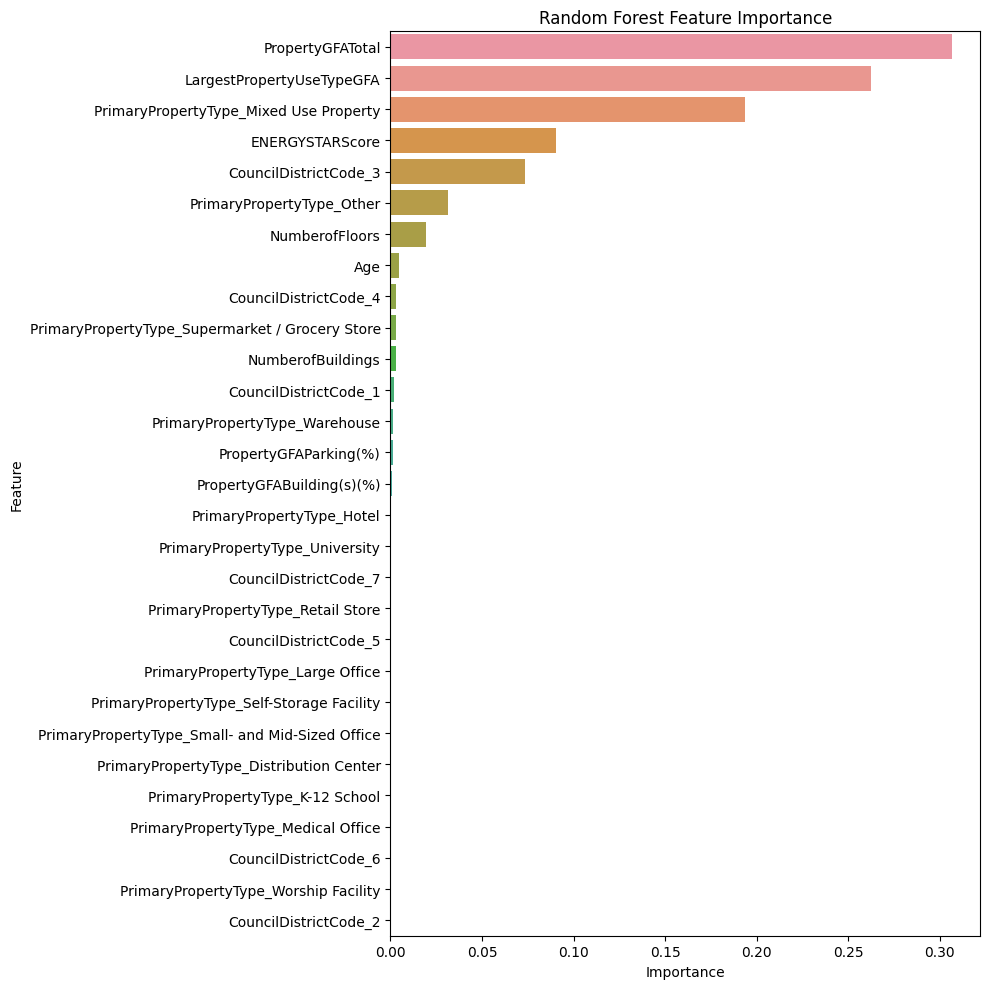

In [156]:
feat_imp_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
feat_imp_rf = feat_imp_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=feat_imp_rf)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

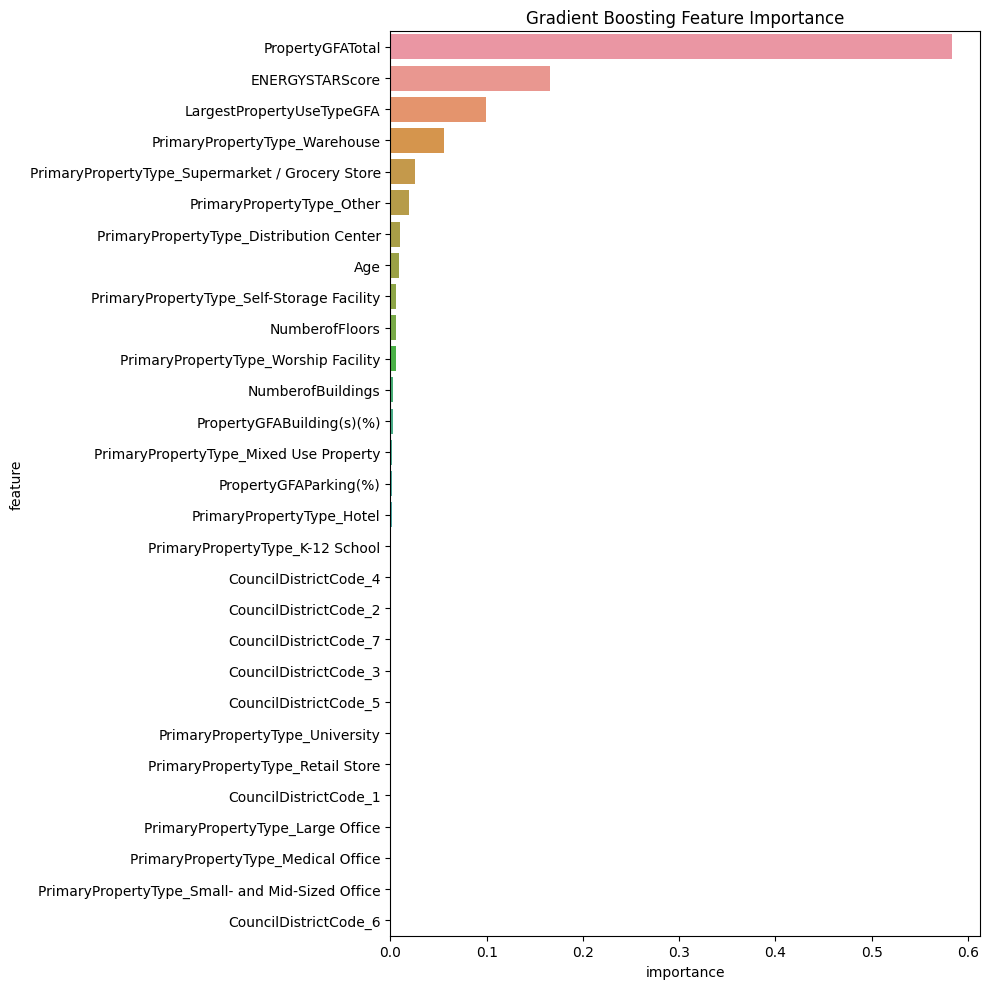

In [159]:
feat_imp_gb_tt = pd.DataFrame({'importance': tt_gb.regressor_.feature_importances_})
feat_imp_gb_tt['feature'] = X_train.columns
feat_imp_gb_tt = feat_imp_gb_tt.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feat_imp_gb_tt)
plt.title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()

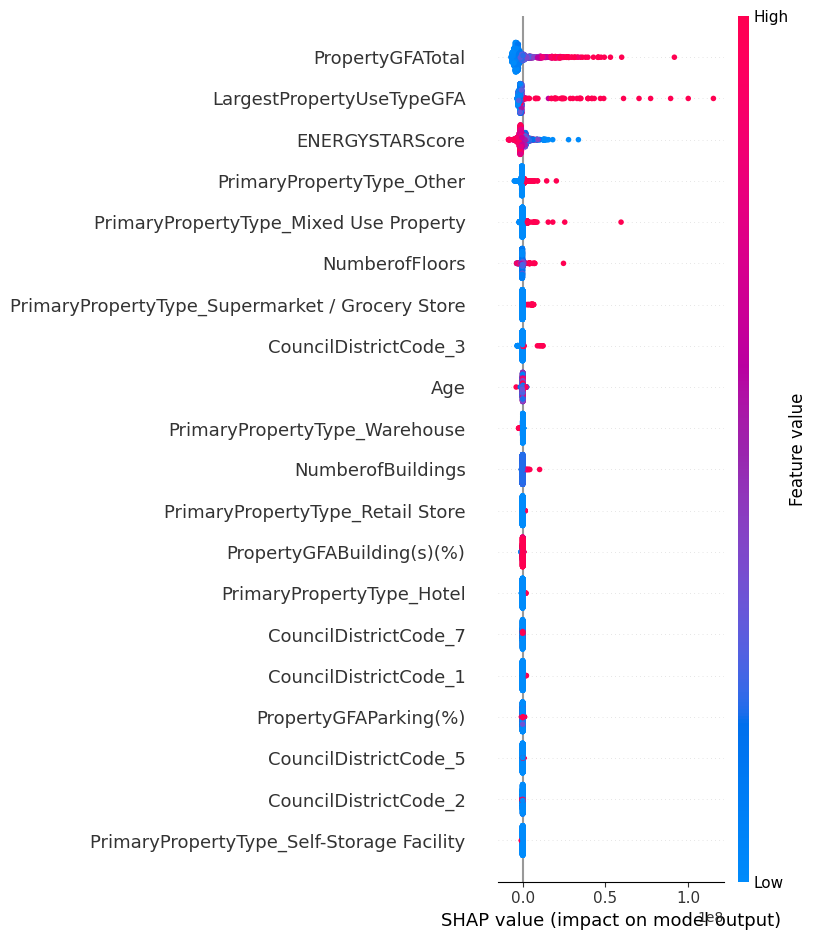

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
X_train_tt_drop_ESS = X_train_tt.drop(['ENERGYSTARScore'], axis=1)
X_test_tt_drop_ESS = X_test_tt.drop(['ENERGYSTARScore'], axis=1)
X_train_drop_ESS = X_train.drop(['ENERGYSTARScore'], axis=1)
X_test_drop_ESS = X_test.drop(['ENERGYSTARScore'], axis=1)

In [ ]:
"""tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
params = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],
            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],
            'regressor__max_depth': [4, 6],
            'regressor__min_samples_leaf': [3, 5, 9, 17]}
grid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_tt_gb.fit(X_train_tt_drop_ESS, y_train)
best_params_gb_tt = grid_tt_gb.best_params_
resultize(grid_tt_gb).head()"""
#30s

"tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),\n                                    func=np.log1p,\n                                    inverse_func=np.expm1)\nparams = {'regressor__loss': ['ls', 'lad', 'huber', 'quantile'],\n            'regressor__learning_rate': [0.1, 0.05, 0.02, 0.01],\n            'regressor__max_depth': [4, 6],\n            'regressor__min_samples_leaf': [3, 5, 9, 17]}\ngrid_tt_gb = GridSearchCV(tt_gb, params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_tt_gb.fit(X_train_tt_drop_ESS, y_train)\nbest_params_gb_tt = grid_tt_gb.best_params_\nresultize(grid_tt_gb).head()"

In [ ]:
best_params_gb_tt = {'learning_rate': 0.1,
      'loss': 'huber',
      'max_depth': 4,
      'min_samples_leaf': 9}

In [ ]:
tt_gb = TransformedTargetRegressor(regressor=GradientBoostingRegressor(**best_params_gb_tt),
                                    func=np.log1p,
                                    inverse_func=np.expm1)
tt_gb.fit(X_train_tt_drop_ESS, y_train)
y_pred = tt_gb.predict(X_test_tt_drop_ESS)
tt_gb_error_ESS = mean_squared_error(y_test, y_pred, squared=False)
tt_gb_error_ESS

15323830.286923578

In [ ]:
tt_gb_error

12388904.813796815

In [ ]:
"""params = {'n_estimators': [10, 100, 1000],
            'max_depth': [1, 10, 100, 1000],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]}
grid_rf = GridSearchCV(RandomForestRegressor(), params, cv = 10, scoring = s, refit = score, n_jobs=-1)
grid_rf.fit(X_train_drop_ESS, y_train)
best_params_rf = grid_rf.best_params_
resultize(grid_rf).head()"""
#1mn

"params = {'n_estimators': [10, 100, 1000],\n            'max_depth': [1, 10, 100, 1000],\n            'min_samples_split': [2, 5, 10],\n            'min_samples_leaf': [1, 2, 4]}\ngrid_rf = GridSearchCV(RandomForestRegressor(), params, cv = 10, scoring = s, refit = score, n_jobs=-1)\ngrid_rf.fit(X_train_drop_ESS, y_train)\nbest_params_rf = grid_rf.best_params_\nresultize(grid_rf).head()"

In [ ]:
best_params_rf = {'max_depth': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 10}

In [ ]:
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train_drop_ESS, y_train)
y_pred = rf.predict(X_test_drop_ESS)
rf_error_ESS = mean_squared_error(y_test, y_pred, squared=False)
rf_error_ESS

17249192.596201524

In [ ]:
rf_error

13206949.875915967